In [3]:
import pandas as pd

# Replace with your actual path
s3_csv_path = 's3://raw-data-714/daily_accidents_with_features.csv'

# If you have AWS credentials set up in your environment, this will "just work"
final_df = pd.read_csv(s3_csv_path, storage_options={'anon': False})  # anon=False if it's a private bucket

final_df.head()


,Start_Time,accident_count,severity_1,severity_2,severity_3,severity_4,Temp_avg,Humidity_avg,weather_mode,traffic_signal_prop,...,city_Miami,city_Nashville,city_Raleigh,day_of_week,is_weekend,month,year,accident_count_7d_avg,accident_count_7d_std,accident_count_lag1
0,2016-01-14,7.0,0.0,0,0.0,7,31.000000,69.000000,Fair,0.000000,...,0,0,0,3,0,1,2016,7.00,NaN,NaN
1,2016-02-08,60.0,0.0,42,17.0,1,35.239583,91.576389,Overcast,0.194444,...,0,0,0,0,0,2,2016,33.50,37.476659,7.0
2,2016-02-09,59.0,0.0,33,20.0,6,23.610952,87.034524,Light Snow,0.100000,...,0,0,0,1,0,2,2016,42.00,30.315013,60.0
3,2016-02-10,49.0,0.0,30,13.0,6,17.410417,78.196970,Light Snow,0.031250,...,0,0,0,2,0,2,2016,43.75,24.998333,59.0
4,2016-02-11,93.0,0.0,66,21.0,6,15.649187,65.771182,Mostly Cloudy,0.117241,...,0,0,0,3,0,2,2016,53.60,30.883653,49.0


# **1. National Accident Trends**
### A. Overall Daily Trend (Line Plot + Rolling Mean)

What to look for:

Long-term trend (rising/falling/flat)

Major drops/spikes

COVID-19 or event impacts

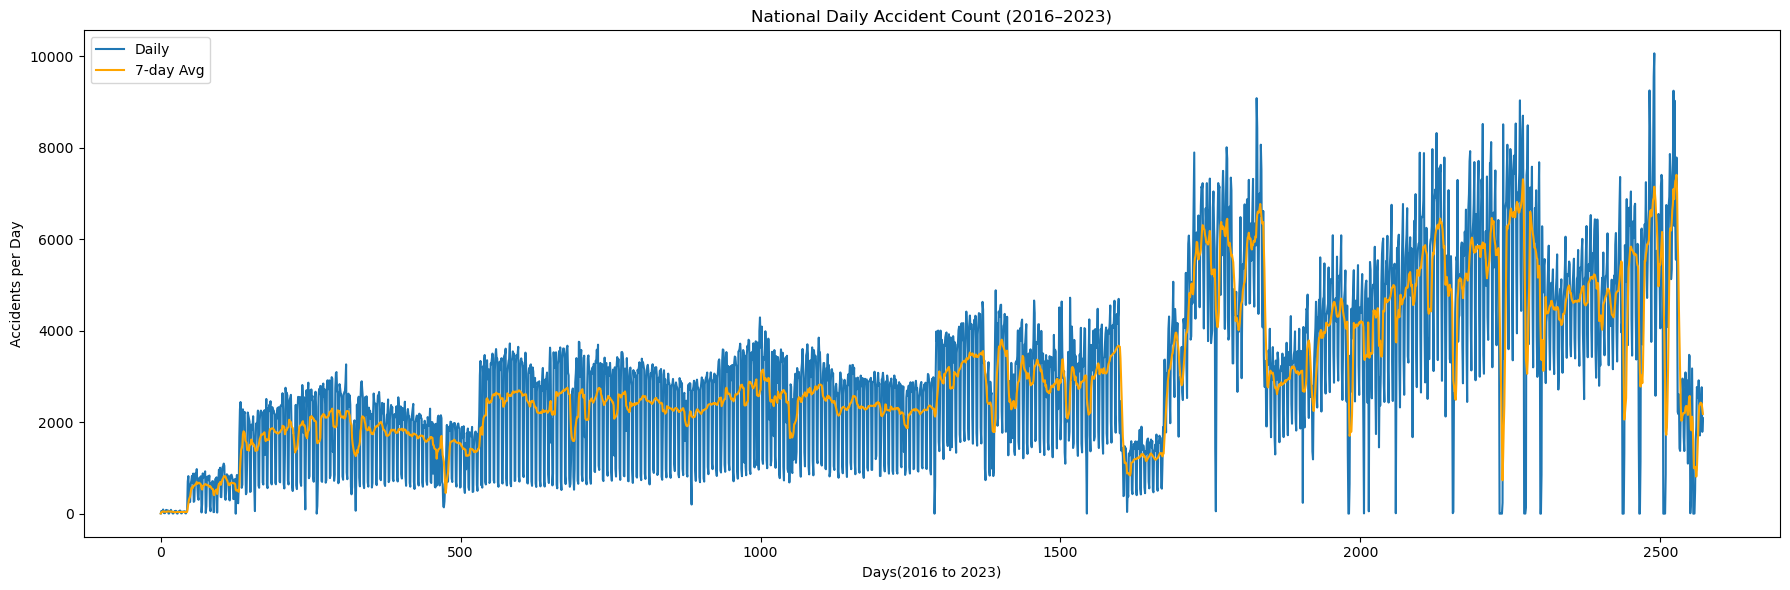

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
sns.lineplot(data=final_df, x=final_df.index, y='accident_count', label='Daily')
sns.lineplot(data=final_df, x=final_df.index, y='accident_count_7d_avg', label='7-day Avg', color='orange')
plt.title('National Daily Accident Count (2016–2023)')
plt.xlabel('Days(2016 to 2023)')
plt.ylabel('Accidents per Day')
plt.legend()
plt.tight_layout()
plt.show()


### B. Monthly/Yearly Trends

What to look for:

Seasonality, annual cycles, unusual months

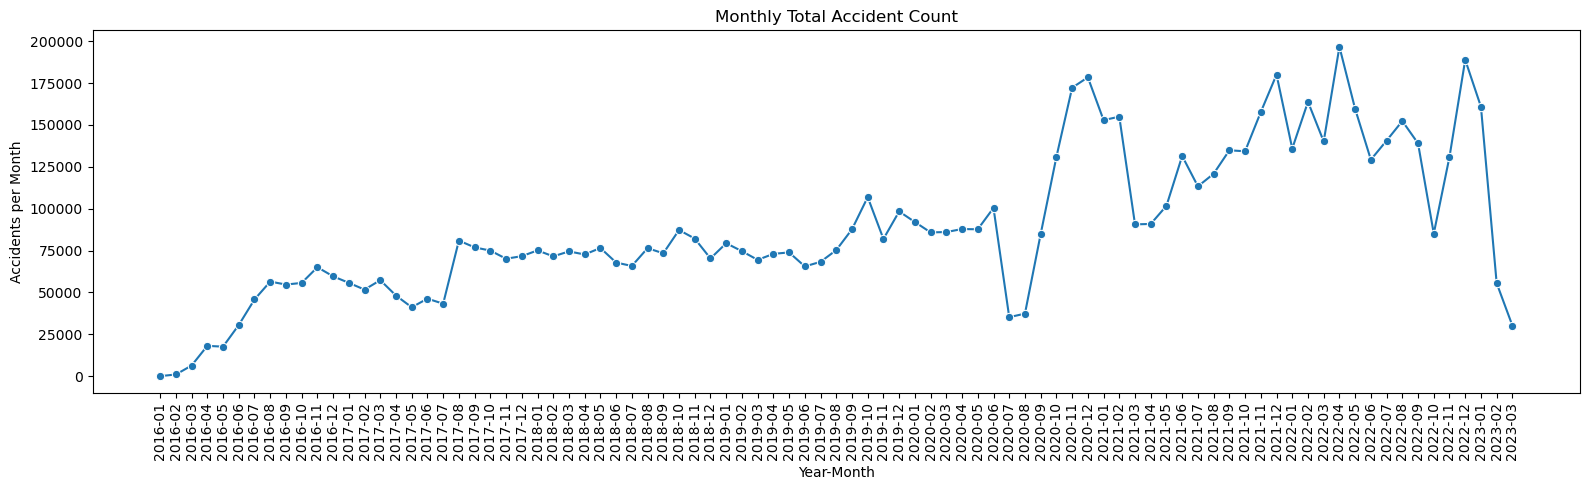

In [16]:
# Ensure the index is datetime, or create a new date column if needed
if not pd.api.types.is_datetime64_any_dtype(final_df.index):
    if 'Start_Time' in final_df.columns:
        dt_source = pd.to_datetime(final_df['Start_Time'])
    else:
        raise ValueError("No datetime index or 'Start_Time' column found.")
else:
    dt_source = final_df.index

final_df['year_month'] = pd.to_datetime(dt_source).dt.to_period('M').astype(str)

# Now continue as before:
monthly = final_df.groupby('year_month')['accident_count'].sum().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))
sns.lineplot(data=monthly, x='year_month', y='accident_count', marker='o')
plt.title('Monthly Total Accident Count')
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Accidents per Month')
plt.tight_layout()
plt.show()


### C. Boxplot: Accident Count by Month

What to look for:

Which months are riskiest/least risky

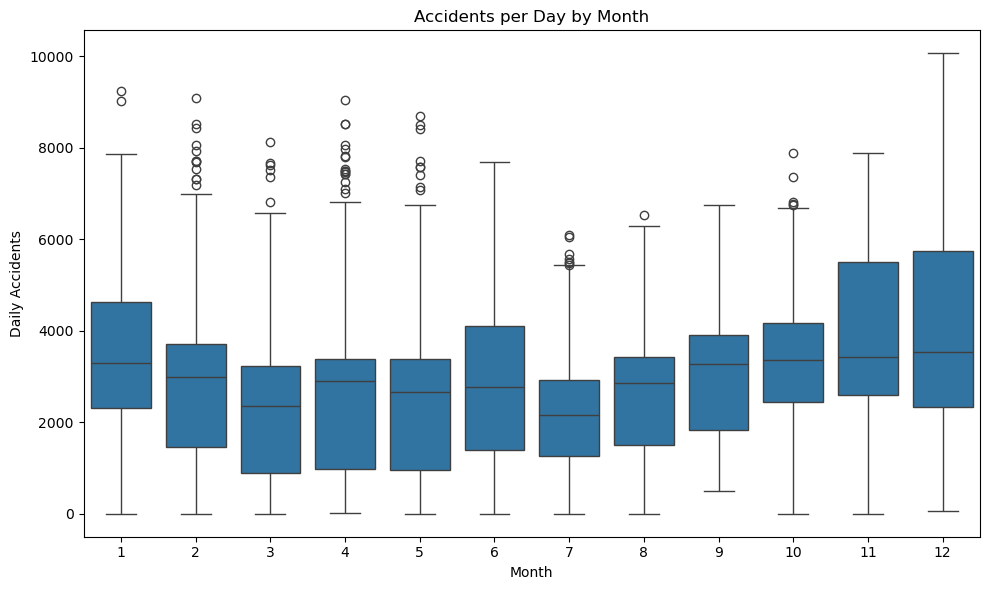

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x='month', y='accident_count', data=final_df)
plt.title('Accidents per Day by Month')
plt.xlabel('Month')
plt.ylabel('Daily Accidents')
plt.tight_layout()
plt.show()


# **2. City-Level Patterns**
### A. Top Cities: Daily Rolling Means

What to look for:

Which cities lead in accidents, and how do their trends compare?

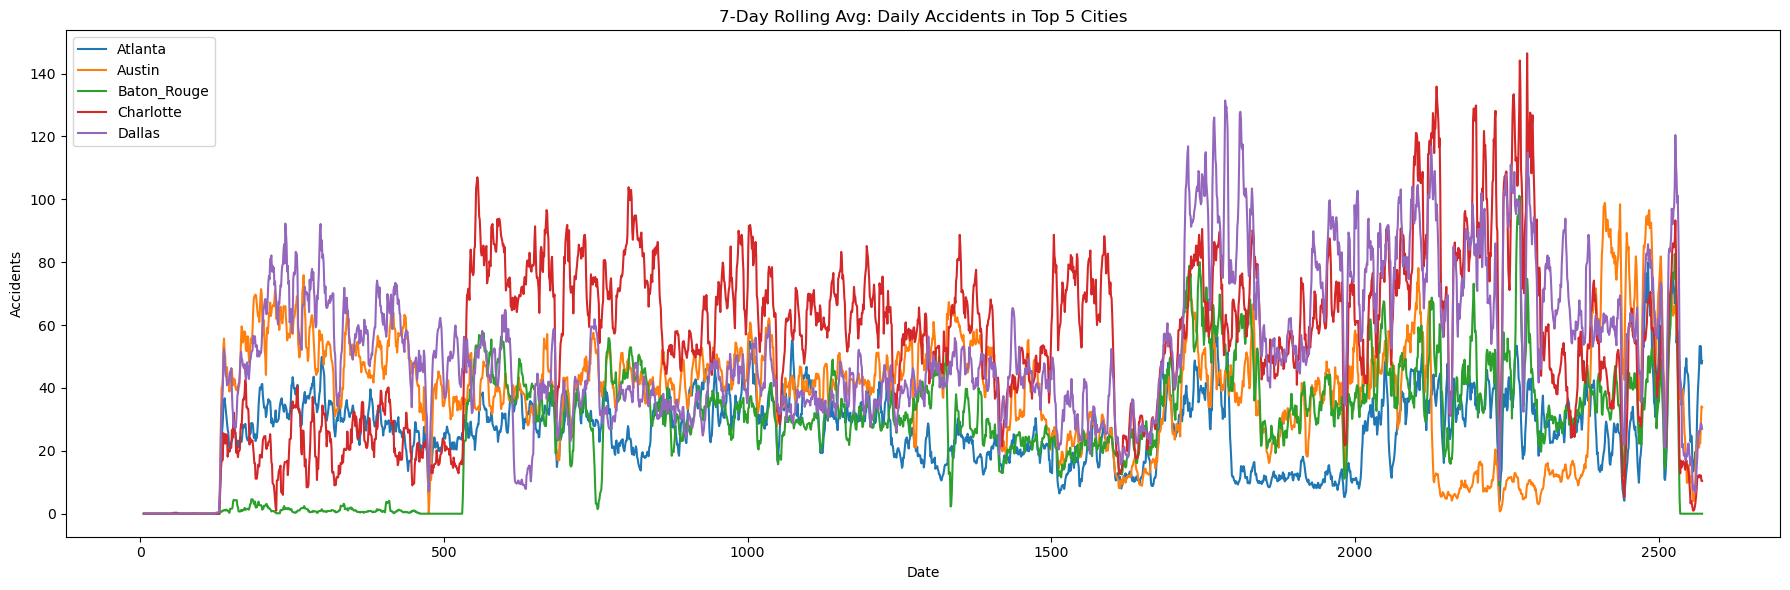

In [23]:
top_city_cols = [col for col in final_df.columns if col.startswith('city_')]
plt.figure(figsize=(18,6))
for city in top_city_cols[:5]:  # show top 5 for readability
    sns.lineplot(x=final_df.index, y=final_df[city].rolling(7).mean(), label=city.replace('city_', ''))
plt.title('7-Day Rolling Avg: Daily Accidents in Top 5 Cities')
plt.xlabel('Date')
plt.ylabel('Accidents')
plt.legend()
plt.tight_layout()
plt.show()


### B. City Volatility and Peaks

What to look for:

Which cities have the highest/most volatile accident rates?

In [25]:
city_stats = pd.DataFrame({
    'mean': [final_df[c].mean() for c in top_city_cols],
    'std': [final_df[c].std() for c in top_city_cols],
    'max': [final_df[c].max() for c in top_city_cols]
}, index=[c.replace('city_', '') for c in top_city_cols])
display(city_stats.sort_values('mean', ascending=False))


,mean,std,max
Miami,72.673795,104.071486,818
Houston,65.944401,43.972539,283
Los_Angeles,60.844090,36.808367,266
Charlotte,53.908243,43.469300,268
Dallas,50.909409,34.742481,237
Austin,37.853421,28.842804,143
Raleigh,33.467729,29.846687,183
Nashville,28.355365,25.760296,161
Baton_Rouge,27.833593,26.298904,190
Atlanta,26.510886,18.435320,141


# **3. Severity Analysis**
### A. Stacked Area Plot by Severity
What to look for:

Are minor/major accidents shifting over time?



<Figure size 2400x800 with 0 Axes>

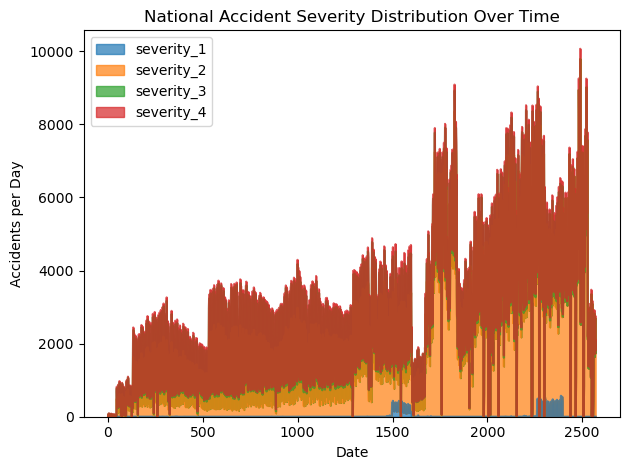

In [28]:
sev_cols = [c for c in final_df.columns if c.startswith('severity_')]
plt.figure(figsize=(24,8))
final_df[sev_cols].plot.area(stacked=True, alpha=0.7)
plt.title('National Accident Severity Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Accidents per Day')
plt.tight_layout()
plt.show()


# **4. Weather Impact**
### A. Accident Count by Weather Mode

What to look for:

Weather types with higher/lower risk

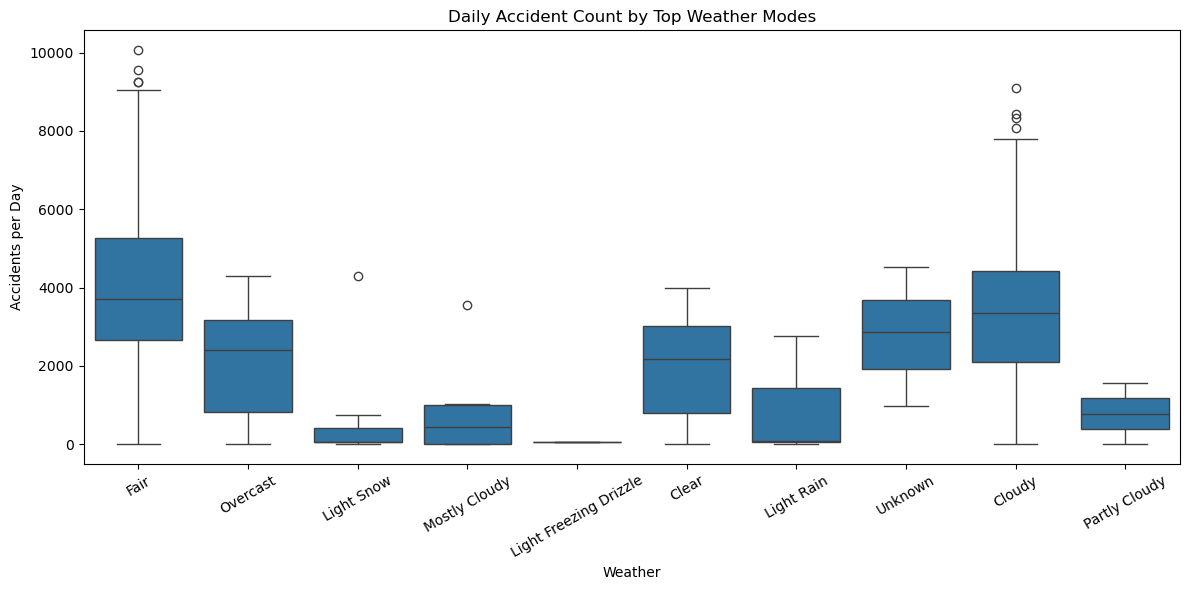

In [46]:
top_weather = final_df['weather_mode'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='weather_mode', y='accident_count', data=final_df[final_df['weather_mode'].isin(top_weather)])
plt.title('Daily Accident Count by Top Weather Modes')
plt.xlabel('Weather')
plt.ylabel('Accidents per Day')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### B. Correlation: Temp, Humidity, Accidents

What to look for:

Is there a correlation or threshold effect?

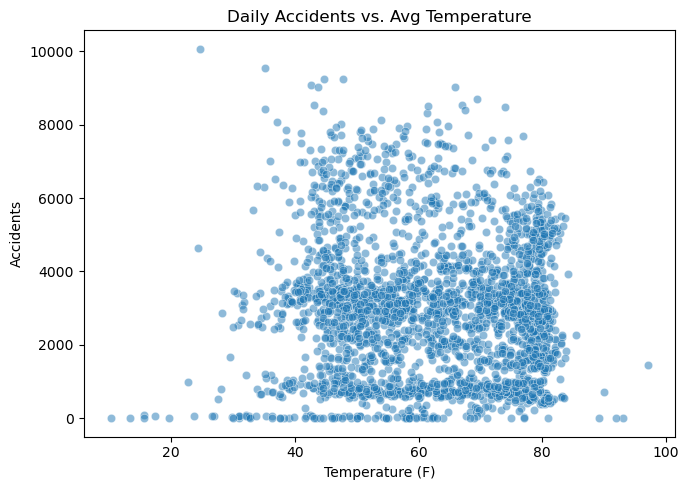

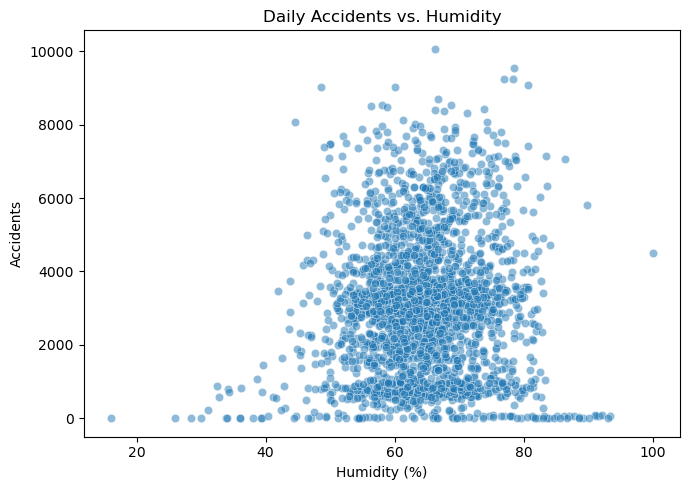

In [45]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='Temp_avg', y='accident_count', data=final_df, alpha=0.5)
plt.title('Daily Accidents vs. Avg Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Accidents')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='Humidity_avg', y='accident_count', data=final_df, alpha=0.5)
plt.title('Daily Accidents vs. Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Accidents')
plt.tight_layout()
plt.show()


# **5. Traffic Signal & Time Features**
### A. Accident Rate: Weekday vs Weekend
What to look for:

Is the weekend more dangerous?



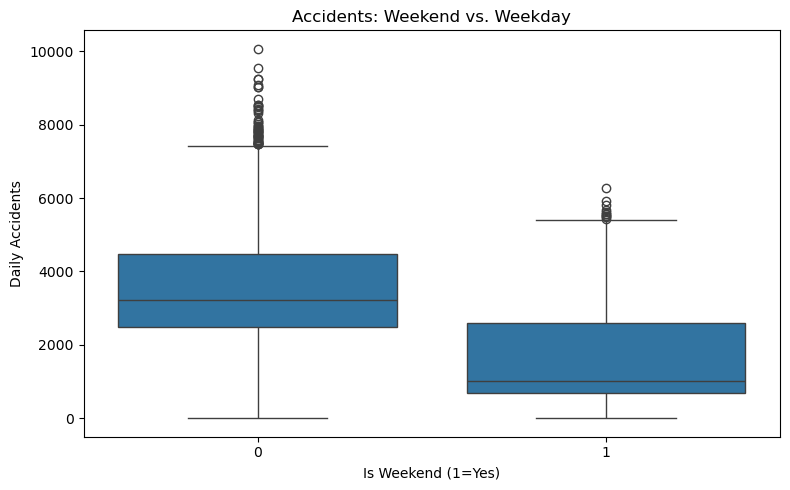

In [48]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_weekend', y='accident_count', data=final_df)
plt.title('Accidents: Weekend vs. Weekday')
plt.xlabel('Is Weekend (1=Yes)')
plt.ylabel('Daily Accidents')
plt.tight_layout()
plt.show()


### B. Traffic Signal Proportion vs Accidents

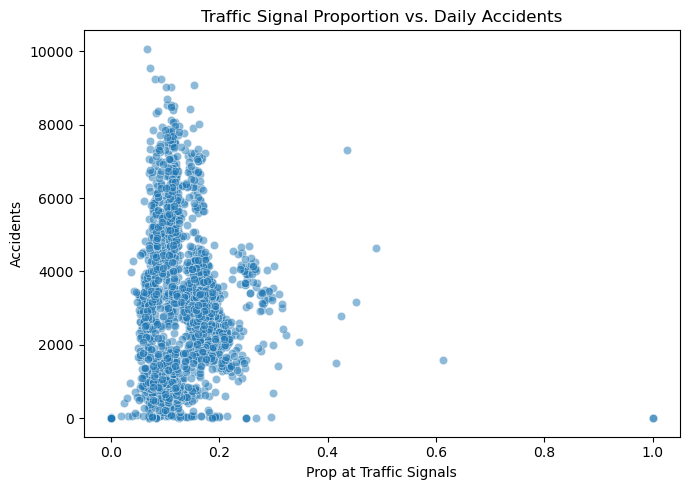

In [49]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='traffic_signal_prop', y='accident_count', data=final_df, alpha=0.5)
plt.title('Traffic Signal Proportion vs. Daily Accidents')
plt.xlabel('Prop at Traffic Signals')
plt.ylabel('Accidents')
plt.tight_layout()
plt.show()


# **7. Correlation & Feature Importance**
### A. Correlation Heatmap

What to look for:

What features are most correlated with accident counts?

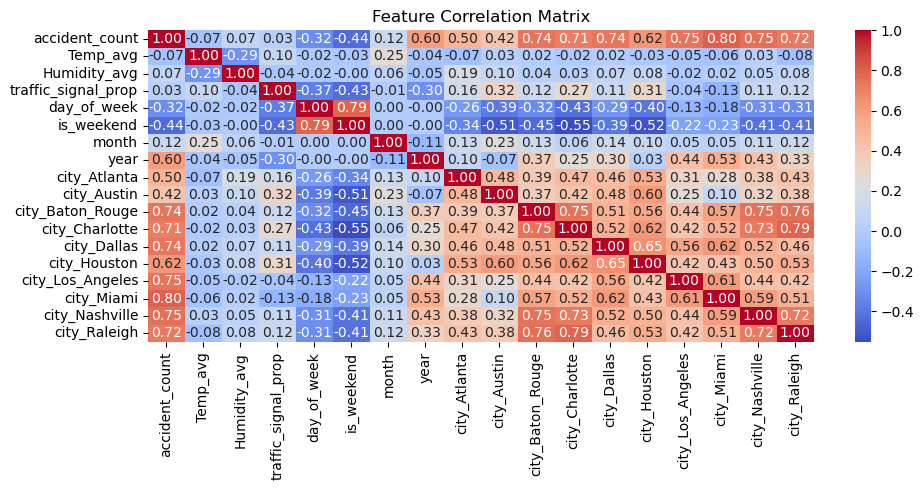

In [52]:
features = [
    'accident_count', 'Temp_avg', 'Humidity_avg', 'traffic_signal_prop', 
    'day_of_week', 'is_weekend', 'month', 'year'
] + top_city_cols
plt.figure(figsize=(10,5))
sns.heatmap(final_df[features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


# **Forecasting Readiness**
### A. Plot ACF/PACF for Forecastability
What to look for:

Seasonality, persistence, and forecastable structure

<Figure size 1400x500 with 0 Axes>

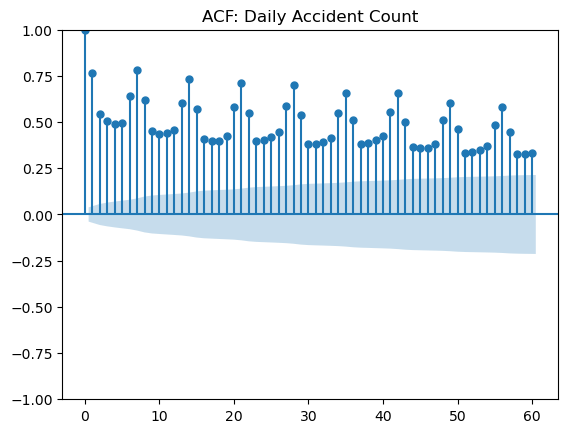

<Figure size 1400x500 with 0 Axes>

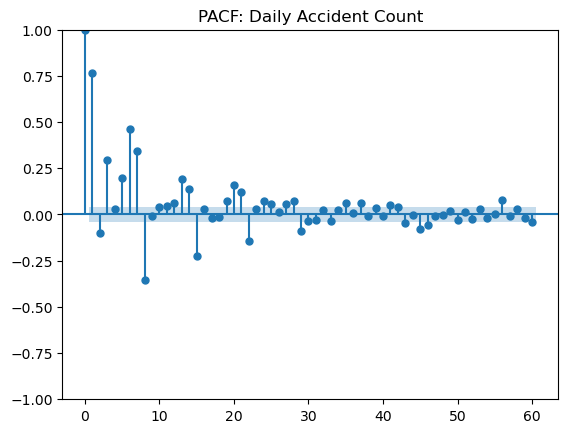

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14,5))
plot_acf(final_df['accident_count'].dropna(), lags=60)
plt.title('ACF: Daily Accident Count')
plt.show()

plt.figure(figsize=(14,5))
plot_pacf(final_df['accident_count'].dropna(), lags=60)
plt.title('PACF: Daily Accident Count')
plt.show()
